In [258]:
import numpy as np
import pandas as pd
from sklearn.decomposition import PCA
from matplotlib import pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn import linear_model

In [259]:
df = pd.read_csv('healthcare-dataset-stroke-data.csv')

In [260]:
df.head()

,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,9046,Male,67.0,0,1,Yes,Private,Urban,228.69,36.6,formerly smoked,1
1,51676,Female,61.0,0,0,Yes,Self-employed,Rural,202.21,NaN,never smoked,1
2,31112,Male,80.0,0,1,Yes,Private,Rural,105.92,32.5,never smoked,1
3,60182,Female,49.0,0,0,Yes,Private,Urban,171.23,34.4,smokes,1
4,1665,Female,79.0,1,0,Yes,Self-employed,Rural,174.12,24.0,never smoked,1


In [261]:
df['gender'] = df['gender'].apply(lambda x: 1 if x=='Male' else 0)
df['ever_married'] = df['ever_married'].apply(lambda x: 1 if x=='Yes' else 0)
df['work_type'] = df['work_type'].apply(lambda x: 1 if x=='Private' else 0)
df['Residence_type'] = df['Residence_type'].apply(lambda x: 1 if x=='Urban' else 0)
df['smoking_status'] = df['smoking_status'].apply(lambda x: 2 if x=='smokes' else 1 if x=='formerly smoked' else 0)
df = df.drop(['id'],axis=1)

In [262]:
df.head()

,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,1,67.0,0,1,1,1,1,228.69,36.6,1,1
1,0,61.0,0,0,1,0,0,202.21,NaN,0,1
2,1,80.0,0,1,1,1,0,105.92,32.5,0,1
3,0,49.0,0,0,1,1,1,171.23,34.4,2,1
4,0,79.0,1,0,1,0,0,174.12,24.0,0,1


In [263]:
na_rows = df[df.isna().any(axis=1)]
na_rows

,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
1,0,61.0,0,0,1,0,0,202.21,NaN,0,1
8,0,59.0,0,0,1,1,0,76.15,NaN,0,1
13,1,78.0,0,1,1,1,1,219.84,NaN,0,1
19,1,57.0,0,1,0,0,1,217.08,NaN,0,1
27,1,58.0,0,0,1,1,0,189.84,NaN,0,1
...,...,...,...,...,...,...,...,...,...,...,...
5039,1,41.0,0,0,0,1,0,70.15,NaN,1,0
5048,1,40.0,0,0,1,1,1,191.15,NaN,2,0
5093,0,45.0,1,0,1,0,0,95.02,NaN,2,0
5099,1,40.0,0,0,1,1,0,83.94,NaN,2,0


In [264]:
#To Fill BMI NaN We will first create a model to predict that value (TODO)
lin_reg = linear_model.LinearRegression()
lin_reg.fit(df.drop(na_rows.index).drop(['bmi','stroke'],axis=1),df.drop(na_rows.index)['bmi'])
bmi_predictions = pd.Series(na_rows['bmi'].apply(lambda x: lin_reg.predict(na_rows.drop(['bmi','stroke'],axis=1))).values)

In [265]:
df = df.fillna(df.mean())

In [266]:
na_rows = df[df.isna().any(axis=1)]
na_rows

,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke


In [267]:
test = df.sample(frac=0.2,random_state=200)
df = df.drop(test.index)

In [268]:
X = np.array(df)[:,:-1]
Y = np.array(df)[:,-1]

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y, data. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


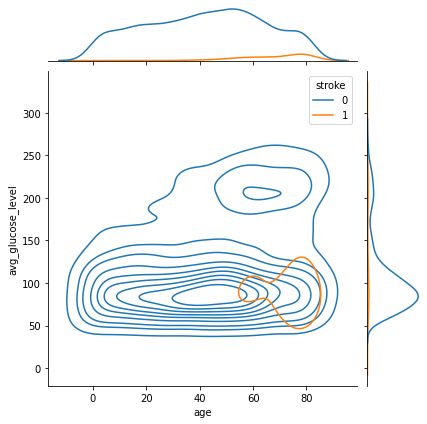

In [269]:
best_columns = list(df.columns[np.where(SelectKBest(chi2, k=2).fit(X,Y).get_support())])
sns.jointplot(best_columns[0],best_columns[1],df,hue='stroke',kind='kde')

In [270]:
def precision(Pred, Y):
  '''
  Returns precision - percentage of positive values model predicted as positive

  Parameters
  ------------
  Pred - Predicted Values
  Y - Ground Truth

  Returns precision
  '''
  return (
        sum(np.logical_and((Pred == Y),Y==1)) / 
        sum(Y==1)
  ) 
def recall(Pred,Y):
  '''
  Returns recall - percentage of all predicted positive values that are actually positive

  Parameters
  ------------
  Pred - Predicted Values
  Y - Ground Truth

  Returns recall
  '''
  return (
        sum(np.logical_and(Pred==1,Y==1)) / 
        sum(Pred==1)
  ) 



In [271]:
#Random Forest is a Good Classifier for Somewhat Categorical Data
rf = RandomForestClassifier(n_estimators = 101,max_depth = 3)
rf.fit(X,Y)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=3, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=101,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [272]:
X_test = np.array(test)[:,:-1]
Y_test = np.array(test)[:,-1]

In [273]:
rf.score(X_test,Y_test)

0.9540117416829745

In [274]:
precision(np.array(rf.predict(X_test)),np.array(Y_test))

0.0

In [275]:
##Divided by zero so nan
recall(np.array(rf.predict(X_test)),np.array(Y_test))

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in long_scalars
  if __name__ == '__main__':


nan

In [276]:
#Need To ReWeight Classes as Never Predicts Stroke
rf = RandomForestClassifier(n_estimators = 101,max_depth = 3,class_weight={0:1.,1:10.})
rf.fit(X,Y)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                       class_weight={0: 1.0, 1: 10.0}, criterion='gini',
                       max_depth=3, max_features='auto', max_leaf_nodes=None,
                       max_samples=None, min_impurity_decrease=0.0,
                       min_impurity_split=None, min_samples_leaf=1,
                       min_samples_split=2, min_weight_fraction_leaf=0.0,
                       n_estimators=101, n_jobs=None, oob_score=False,
                       random_state=None, verbose=0, warm_start=False)

In [277]:
rf.score(X_test,Y_test)

0.8669275929549902

In [278]:
precision(np.array(rf.predict(X_test)),np.array(Y_test))

0.5531914893617021

In [279]:
recall(np.array(rf.predict(X_test)),np.array(Y_test))

0.18439716312056736

In [232]:
#Running Logistic Regression Is Beneficial If we Want a Probability Attached
log_reg = linear_model.LogisticRegression()
log_reg.fit(X,Y)

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [233]:
log_reg.score(X_test,Y_test)

0.9412915851272016

In [250]:
precision(np.array(log_reg.predict(X_test)),np.array(Y_test))

0.0

In [251]:
recall(np.array(log_reg.predict(X_test)),np.array(Y_test))

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in long_scalars
  if __name__ == '__main__':


nan

In [280]:
#Same case, so lets reweight our logistic regression model
log_reg = linear_model.LogisticRegression(class_weight = {0:1.,1:10.})
log_reg.fit(X,Y)

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


LogisticRegression(C=1.0, class_weight={0: 1.0, 1: 10.0}, dual=False,
                   fit_intercept=True, intercept_scaling=1, l1_ratio=None,
                   max_iter=100, multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [281]:
log_reg.score(X_test,Y_test)

0.8258317025440313

In [282]:
precision(np.array(log_reg.predict(X_test)),np.array(Y_test))

0.6808510638297872

In [283]:
recall(np.array(log_reg.predict(X_test)),np.array(Y_test))

0.1641025641025641